In [1]:
%matplotlib inline
import copy
import torch
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import gru_ode_bayes 
import gru_ode_bayes.data_utils as data_utils
import time
from tqdm import tqdm
from sklearn.metrics import roc_auc_score
from gru_ode_bayes import Logger
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
file_path="D:/mimic_iii/clean_data/"
csv_file_path =file_path+"GRU_ODE_Dataset.csv"
covs_file_path=file_path+"GRU_ODE_covariates.csv"
tags_file_path=file_path+"GRU_ODE_death_tags.csv"

In [3]:
import pickle

def pickle_dump(obj, path):
    with open(path, mode='wb') as f:
        pickle.dump(obj,f)

def pickle_load(path):
    with open(path, mode='rb') as f:
        data = pickle.load(f)
        return data

In [4]:
# ロード
d=pickle_load( file_path+'sample_unique_id_dict.pickle')


In [5]:
idx=np.array(list(d.keys()))

In [6]:
dir_path=r"D:/mimic_iii/clean_data/"
test_idx = np.load(dir_path+r"fold_idx_0/test_idx.npy")

In [7]:
# data_train = data_utils.ODE_Dataset(csv_file=csv_file_path,label_file=tags_file_path, cov_file=covs_file_path, idx=idx)

In [8]:
data_test   = data_utils.ODE_Dataset(csv_file=csv_file_path,label_file=tags_file_path,
                                    cov_file= covs_file_path, idx=test_idx, validation = False,
                                    val_options =None)

In [9]:
dl   = DataLoader(dataset=data_test, collate_fn=data_utils.custom_collate_fn, shuffle=True, batch_size=500,num_workers=4)

In [10]:
#Model parameters.
params_dict=dict()
params_dict["hidden_size"] = 100
params_dict["p_hidden"] = 25
params_dict["prep_hidden"] = 10
params_dict["logvar"] = True
params_dict["mixing"] = 1e-4 #Weighting between KL loss and MSE loss.
params_dict["delta_t"]=0.1
params_dict["T"]= 100  #100
# lambda>0のときClassificationを行う
params_dict["lambda"] = 1 #Weighting between classification and MSE loss.
# lambda==0でないとき、validationオプションはなしにされている(validation==False)
# validationがないときは、summaryのcorrelation,validation_mse,loglik_lossは計算されず0で記録される

params_dict["classification_hidden"] = 2
params_dict["cov_hidden"] = 50
params_dict["weight_decay"] = 0.0001
params_dict["dropout_rate"] = 0
params_dict["lr"]=0.001
params_dict["full_gru_ode"] = True
params_dict["no_cov"] = False # covファイルが存在するときFalse
params_dict["impute"] = False


params_dict["input_size"]=data_test.variable_num
params_dict["cov_size"] = data_test.cov_dim

In [11]:
# model instance 生成
device = torch.device("cuda")
model = gru_ode_bayes.NNFOwithBayesianJumps(input_size = params_dict["input_size"], hidden_size = params_dict["hidden_size"],
                                            p_hidden = params_dict["p_hidden"], prep_hidden = params_dict["prep_hidden"],
                                            logvar = params_dict["logvar"], mixing = params_dict["mixing"],
                                            classification_hidden=params_dict["classification_hidden"],
                                            cov_size = params_dict["cov_size"], cov_hidden = params_dict["cov_hidden"],
                                            dropout_rate = params_dict["dropout_rate"],full_gru_ode= params_dict["full_gru_ode"], impute = params_dict["impute"])
model.to(device)
model.eval()

NNFOwithBayesianJumps(
  (p_model): Sequential(
    (0): Linear(in_features=100, out_features=25, bias=True)
    (1): ReLU()
    (2): Dropout(p=0, inplace=False)
    (3): Linear(in_features=25, out_features=192, bias=True)
  )
  (classification_model): Sequential(
    (0): Linear(in_features=100, out_features=2, bias=True)
    (1): ReLU()
    (2): Dropout(p=0, inplace=False)
    (3): Linear(in_features=2, out_features=1, bias=True)
  )
  (gru_c): FullGRUODECell_Autonomous(
    (lin_hh): Linear(in_features=100, out_features=100, bias=False)
    (lin_hz): Linear(in_features=100, out_features=100, bias=False)
    (lin_hr): Linear(in_features=100, out_features=100, bias=False)
  )
  (gru_obs): GRUObservationCellLogvar(
    (gru_d): GRUCell(960, 100)
    (gru_debug): GRUCell(960, 100)
  )
  (covariates_map): Sequential(
    (0): Linear(in_features=530, out_features=50, bias=True)
    (1): ReLU()
    (2): Dropout(p=0, inplace=False)
    (3): Linear(in_features=50, out_features=100, bias=True

In [12]:
# model parameter load
model_path = r'D:/mimic_iii/clean_data/trained_models/Xval_AUC_GRU_ODE_MIMIC_Binned2_NoImpute_dropout0.1_weightdecay0.0001_lambda1_fold0_MAX.pt'
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [13]:
tmp = dl.__iter__()
b = tmp.next() 

In [14]:
# var=64
# for i in range(100):
#     tmp = dl.__iter__()
#     b = tmp.next() 
#     if b["X"][:,var].sum()!=0:
#          break

In [14]:
var=0
for i in range(100):
    tmp = dl.__iter__()
    b = tmp.next() 
    b_new=copy.deepcopy(b["X"])
    temp=np.array(b_new[:,var][:])
    if np.average(temp[np.where(temp!=0)])>0.5:
         break

In [15]:
b_new=copy.deepcopy(b["X"])
print(b_new[:,var])
temp=np.array(b_new[:,var][:])
b_new[:,var][:]=torch.tensor(np.average(temp[np.where(temp!=0)]))
b_new[:,var]

tensor([0., 0., 0.,  ..., 0., 0., 0.])


tensor([0.0316, 0.0316, 0.0316,  ..., 0.0316, 0.0316, 0.0316])

In [16]:
# for i, b in enumerate(dl):
times    = b["times"]
time_ptr = b["time_ptr"]
X        = b["X"].to(device)
X2 =b_new.to(device)
M        = b["M"].to(device)
obs_idx  = b["obs_idx"]
cov      = b["cov"].to(device)
labels   = b["y"].to(device)
batch_size = labels.size(0)
# if b["X_val"] is not None:
#     X_val     = b["X_val"].to(device)
#     M_val     = b["M_val"].to(device)
#     times_val = b["times_val"]
#     times_idx = b["index_val"]
h0 = 0 #torch.zeros(labels.shape[0], params_dict["hidden_size"]).to(device)

In [17]:

hT, loss, class_pred, t_vec, p_vec, h_vec, _, _ ,_,_ = model(times, time_ptr, X, M, obs_idx, delta_t=params_dict["delta_t"], T=params_dict["T"], cov=cov, return_path=True)

In [18]:

hT, loss, class_pred, t_vec, p_vec_2, h_vec_2, _, _,_,_  = model(times, time_ptr, X2, M, obs_idx, delta_t=params_dict["delta_t"], T=params_dict["T"], cov=cov, return_path=True)

In [21]:
comp=pd.read_csv( "D:mimic_iii/clean_data/complete_tensor_train1.csv")

In [22]:
a=comp[(comp["LABEL_CODE"].isin([0,17,32,46,64]))].drop_duplicates(subset='LABEL_CODE').reset_index()
a

,index,Unnamed: 0,UNIQUE_ID,LABEL_CODE,TIME_STAMP,VALUENUM,MEAN,STD,VALUENORM
0,12,1195772,11709,0,42.0,14.000000,14.332368,3.957156,-0.083992
1,13,206103,6852,46,59.0,2.299197,2.874900,4.487361,-0.128294
2,14,2194743,18084,32,78.0,30.000000,41.404942,9.482975,-1.202675
3,87,2114863,14416,17,17.0,13.000000,11.025442,2.146921,0.919716
4,1322,450661,5222,64,2.0,21.250000,32.174596,36.132707,-0.302346


In [27]:
len(h_vec[:,0,0])

1099

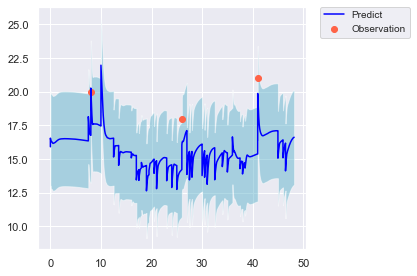

In [22]:
%matplotlib inline
sns.set()
h=h_vec.cpu().detach().numpy()
p=p_vec.cpu().detach().numpy()
obs=np.array(b["X"])
obs_dash=obs[:,var]*float(a[a["LABEL_CODE"]==var]["STD"])+ float(a[a["LABEL_CODE"]==var]["MEAN"])
obs_dash=np.where(obs_dash== float(a[a["LABEL_CODE"]==var]["MEAN"]),None,obs_dash)
mu=p[0:1000,0,var]*float(a[a["LABEL_CODE"]==var]["STD"]) + float(a[a["LABEL_CODE"]==var]["MEAN"])
std=np.exp(p[1000,0,var+96]*0.5)*float(a[a["LABEL_CODE"]==var]["STD"])
plt.plot(t_vec[0:1000]/2,mu,label="Predict",color="blue")
plt.fill_between(t_vec[0:1000]/2,mu+std,mu-std,facecolor="c",alpha=0.5)
plt.scatter(b["times"]/2,obs_dash,label="Observation",color="tomato")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=10)
# plt.show()
plt.tight_layout()
plt.savefig(f"Obs_{var}_with_std.png")

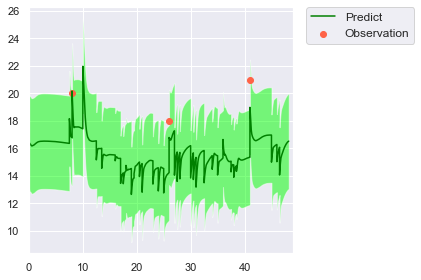

In [23]:
%matplotlib inline
h=h_vec_2.cpu().detach().numpy()
p=p_vec_2.cpu().detach().numpy()
obs=np.array(b["X"])
mu=p[0:1000,0,var]*float(a[a["LABEL_CODE"]==var]["STD"]) + float(a[a["LABEL_CODE"]==var]["MEAN"])
std=np.exp(p[1000,0,var+96]*0.5)*float(a[a["LABEL_CODE"]==var]["STD"])
plt.plot(t_vec[0:1000]/2,mu,label="Predict",color="green")
plt.fill_between(t_vec[0:1000]/2,mu+std,mu-std,facecolor=[0.0, 1.0, 0.0],alpha=0.5)
plt.scatter(b["times"]/2,obs_dash,label="Observation",color="tomato")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=12)
# plt.show()
plt.xlim(0,49)
plt.tight_layout()
plt.savefig(f"NoneObs_{var}_with_std.png")

In [24]:
spec=p*float(a[a["LABEL_CODE"]==var]["STD"]) + float(a[a["LABEL_CODE"]==var]["MEAN"])
np.exp(p[1000,0,96]*0.5)
np.exp(p[1000,0,96]*0.5)*abs(a[a["LABEL_CODE"]==var]["STD"])

0    3.472394
Name: STD, dtype: float64

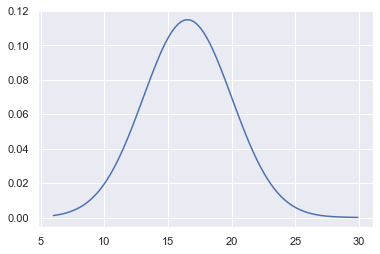

In [27]:
from scipy.stats import norm
x=np.arange(6,30,0.1)
loc=spec[1000,0,var]
scale=np.exp(p[1000,0,var+96]*0.5)*abs(a[a["LABEL_CODE"]==var]["STD"])
plt.plot(x,norm.pdf(x, loc, scale))
plt.savefig("AnionGap_pred_distrib.png")

In [35]:
len(p[1000,0])

192

In [93]:
np.exp(p[:,0,97]*0.5)

array([0.9343381 , 0.08806844, 0.15296291, ..., 0.60258454, 0.6026775 ,
       0.6027706 ], dtype=float32)

In [94]:
p[:,0,0]

array([0.2750019 , 0.75697225, 0.707375  , ..., 0.19837755, 0.19821724,
       0.19806045], dtype=float32)

<AxesSubplot:>

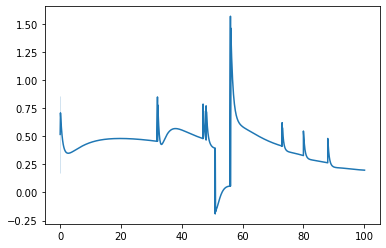

In [97]:
sns.lineplot(x=t_vec,y=p[:,0,0],ci='sd')
# sns.lineplot(x=b["times"],y=np.array(b["X"])[:,0])


In [117]:
np.array(b["X"]!=0).sum(axis=0)

array([2, 2, 1, 2, 2, 3, 1, 1, 2, 2, 0, 0, 0, 2, 1, 1, 2, 3, 1, 2, 2, 2,
       1, 1, 2, 2, 2, 2, 6, 1, 1, 1, 1, 1, 1, 6, 0, 0, 0, 2, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0])